In [1]:
from IPython.display import Image
from oct2py import octave as oct
from os.path import join
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_matlab_data(directory, filename):
    """
    Imports the matlab scripts generated during execution of
        C codes, and returns an array with the data neccesary
        for analysis of performance
    """
    oct.eval(f"cd {directory};")
    oct.eval(f"{filename};")
    oct.eval(f"save -v7 {filename}.mat;")
    data = sio.loadmat(f"{join(directory, filename)}.mat")

    return data['data']

# 1.6.1 Additional exercises
In this section, the course introduces the first excercises in which we use the
**BLIS** and **BLAS** libraries.

## Homework 1.6.1.1
In this week we've already a routine for **matrix - vector** multiplication
called `MyGemv` as
```c
MyGemv(int m, int n, double *A, int ldA, double *x, int incx,
        double *y, int incy)
```
The
[BLIS typed API](https://github.com/flame/blis/blob/master/docs/BLISTypedAPI.md)
contains a similar routine
```c
bli_dgemv( trans_t transa, conj_t conjx, dim_t  m,  dim_t  n, 
           double* alpha, double* a, inc_t rsa, inc_t csa,
                          double* x, inc_t incx, 
           double* beta,  double* y, inc_t incy );
```
this routine supports several variations of **matrix - vector** multiplication.

The homwework consists on copying
[Assignments/Week1/C/Gemm_J_Gemv.c](../Gemm_J_Gemv.c) to `Gemm_J_bli_dgemv.c`
and replace the call to `MyGemv` to a call to `bli_dgemv`, for this, it is also
necessary to include `#include "blis.h"`, the code looks as follows

```c
#include "blis.h"

#define alpha(i, j) A[(j) * ldA + i]   // map alpha( i,j ) to array A 
#define beta(i, j)  B[(j) * ldB + i]   // map beta( i,j )  to array B
#define gamma(i, j) C[(j) * ldC + i]   // map gamma( i,j ) to array C


void MyGemv(int m, int n, double *A, int ldA,
            double *x, int incx, double *y, int incy)

void MyGemm(int m, int n, int k,
			double *A, int ldA,
			double *B, int ldB,
			double *C, int ldC)
{
	for (int j = 0; j < n; j++)
    {
        double d_one=1.0;
        bli_dgemv( BLIS_NO_TRANSPOSE, BLIS_NO_CONJUGATE, m, k, &d_one, A, 1,
                ldA, &beta( 0,j ), 1, &d_one, &gamma( 0,j ), 1 );
	}
}
```

then

```sh
cd Assignments/Week1/C
make J_bli_dgemv
```

## Homework 1.6.1.2
This homework shows the **BLAS** interface, which works by making calls to
fortran
```fortran
DGEMV( TRANSA, M, N, ALPHA, A, LDA, X, INCX, BETA, Y, INCY )
```
which supports the same **matrix - vector** multiplications variants as
`bli_dgemv`. To work with it, copy
[Assignments/Week1/C/Gemm_J_Gemv.c](../Gemm_J_Gemv.c) into `Gemm_J_dgemv` and
replace the call to `MyGemv` with a call to `dgemv`
* When calling `Fortran` code from `C`, we call the routine with lower case
letters and using an underscore `dgemv_`
* We nned a prototype for `dgemv`
* Fortran passes parameters by address

The code looks as
```c
#define alpha(i, j) A[(j) * ldA + i]   // map alpha( i,j ) to array A 
#define beta(i, j)  B[(j) * ldB + i]   // map beta( i,j )  to array B
#define gamma(i, j) C[(j) * ldC + i]   // map gamma( i,j ) to array C

void dgemv_(char *, int *, int *, double *, double *, int *, double *, int *,
        double *, double *, int *);

void MyGemm(int m, int n, int k,
			double *A, int ldA,
			double *B, int ldB,
			double *C, int ldC)
{
	for (int j = 0; j < n; j++)
    {
        int i_one=1;
        double d_one=1.0;
        dgemv_( "No transpose", &m, &k, &d_one, A, &ldA, &beta( 0, j ), &i_one,
                &d_one, &gamma( 0,j ), &i_one ); 
    }
}
```

then
```sh
cd Assignments/Week1/C/
make J_dgemv
```

error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not availabl

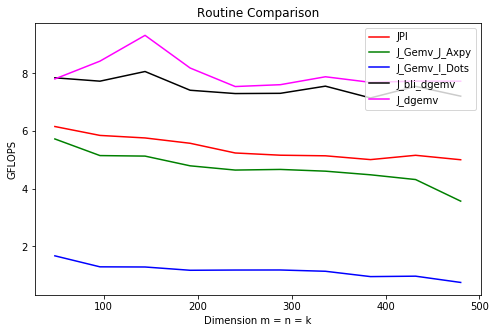

In [3]:
directory = join("..", "data")
filenames = ["output_JPI", "output_J_Gemv_J_Axpy", "output_J_Gemv_I_Dots",
            "output_J_bli_dgemv", "output_J_dgemv"]
labels = ["JPI", "J_Gemv_J_Axpy", "J_Gemv_I_Dots", "J_bli_dgemv", "J_dgemv"]
colors = ["r", "g", "b", "k", "magenta"]

fig_size = [8, 5]
fix, ax = plt.subplots(1, figsize=fig_size)
for file, label, color in zip(filenames, labels, colors):
    data = get_matlab_data(directory, file)
    if np.any(data[:, 5] > 1e-10):
        raise Exception("Hmmm, better check if there is an accuracy problem")
    ax.plot(data[:, 0], data[:, 4], color=color, label=label)
ax.set_title("Routine Comparison")
ax.set_xlabel("Dimension m = n = k")
ax.set_ylabel("GFLOPS")
ax.legend(loc="upper right")
plt.show()

### Conclusion
From this we see that the fact of calling to an optimized
library can improve significantly the performance of our
program.

## Homework 1.6.1.3
We have already written a routine for the **rank-1** update operation
```c
MyGer( int m, int n, double *x, int incx, double *y, int incy, double *A, int ldA )
```
the again, the **BLIS typed API** includes its own routine to perform several
variations of **rank-1** updates.
```c
bli_dger( conj_t conjx, conj_t conjy, dim_t  m,  dim_t  n, 
           double* alpha, double* x, inc_t incx,  double* y, inc_t incy,
           double* A, inc_t rsa,  inc_t csa );
```

Copy [Assignments/Week1/C/Gemm_P_Ger.c](../Gemm_P_Ger.c) into `Gemm_P_bli_dger`
and replace the call to `MyGer`  with a call to `bli_dger`, the code should
look similar to
```c
#include "blis.h"

#define alpha(i, j) A[(j) * ldA + i]   // map alpha( i,j ) to array A 
#define beta(i, j)  B[(j) * ldB + i]   // map beta( i,j )  to array B
#define gamma(i, j) C[(j) * ldC + i]   // map gamma( i,j ) to array C

void MyGer( int, int, double *, int, double *, int, double *, int );

void MyGemm(int m, int n, int k, double *A, int ldA,
		double *B, int ldB, double *C, int ldC)
{
	for (int p=0; p < k; p++)
	{
		double d_one=1.0;
		bli_dger( BLIS_NO_CONJUGATE, BLIS_NO_CONJUGATE, m, n,
				&d_one, &alpha( 0, p ), 1, &beta( p,0 ), ldB, C, 1, ldC );
	}
}
```
then
```sh
cd Assignments/Week1/C/
make P_bli_dger
```

## Homework 1.6.1.4
The original **BLAS** interface has its own **rank-1** update operation, in
Fortran
```fortran
DGER( M, N, ALPHA, X, INCX, Y, INCY, A, LDA );
```
which again, support several variations of **rank-1** update.

Copy [Assignments/Week1/C/Gemm_P_Ger.c](../Gemm_P_Ger.c) into `Gemm_P_dger` and
replace the call to `MyGer` with a call to `dger`, the code should look similar
to
```c
#define alpha(i, j) A[(j) * ldA + i]   // map alpha( i,j ) to array A 
#define beta(i, j)  B[(j) * ldB + i]   // map beta( i,j )  to array B
#define gamma(i, j) C[(j) * ldC + i]   // map gamma( i,j ) to array C

void dger_(int *, int *, double *, double *, int *, double *, int *,
	    double *, int *);

void MyGemm(int m, int n, int k, double *A, int ldA,
	     double *B, int ldB, double *C, int ldC)
{
	int i_one = 1;
	double d_one = 1.0;

	for (int p = 0; p < k; p++)
		dger_(&m, &n, &d_one, &alpha( 0,p ), &i_one, &beta( p,0 ), &ldB, C,
				&ldC);
}
```

then
```sh
cd Assignments/Week1/C/
make P_dger
```


error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not availabl

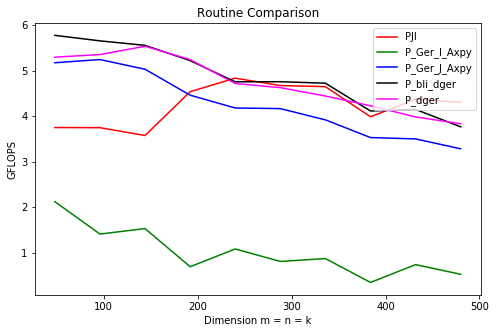

In [4]:
directory = join("..", "data")
filenames = ["output_PJI", "output_P_Ger_I_Axpy", "output_P_Ger_J_Axpy",
            "output_P_bli_dger", "output_P_dger"]
labels = ["PJI", "P_Ger_I_Axpy", "P_Ger_J_Axpy", "P_bli_dger", "P_dger"]
colors = ["r", "g", "b", "k", "magenta"]

fig_size = [8, 5]
fix, ax = plt.subplots(1, figsize=fig_size)
for file, label, color in zip(filenames, labels, colors):
    data = get_matlab_data(directory, file)
    if np.any(data[:, 5] > 1e-10):
        raise Exception("Hmmm, better check if there is an accuracy problem")
    ax.plot(data[:, 0], data[:, 4], color=color, label=label)
ax.set_title("Routine Comparison")
ax.set_xlabel("Dimension m = n = k")
ax.set_ylabel("GFLOPS")
ax.legend(loc="upper right")
plt.show()

### Conclusion
From this **rank-1** example we can conclude that linking to an optimized library does **not** always provides an improvement on the performance of the program.

## Row - Matrix multiplication
We have also seen that **matrix - matrix** multiplication can be performed in
terms of **row - matrix** multiplication operations, from this, we know that we
want a routine that computes
$$
y^T = x^T A + y^T
$$
from linear algebra we know the following rules for the transpose of a matrix
$$
A = B ; A^T = B^T \\
(A + B)^T = A^T + B^T \\
(AB)^T = B^T A^T
$$
with this in mind, we can work our way through a routine for **row - matrix**
operations expressed as **matrix - vector** operations
$$
(y^T)^T = (x^T A + y^T)^T \\
y = (x^T A)^T + (y^T)^T \\
y = A^T (x^T)^T + y \\
y = A^T x + y
$$
hence updating $ y^T = x^T A + y^T $ and $y = A^T x + y$ give the same result.

Now, if
* `A` is a matrix of size `[m x n]` stored in array `A`, with leading
dimension `ldA`.
* `m` and `n` are stored in their corresponding variables `m` and `n`
* vector `x` is stored in array `x` with its stride stored in `incx`
* vector `y` is stored in array `y` with its stride stored in `incy`
* $\alpha$ and $\beta$ are stored in in `alpha` and `beta`
we can call the function `dgemv_` as
```c
dgemv_( "Transpose", &m, &n, &alpha, A, &ldA, x, &incx, &beta, y, &incy );
```

## Homework 1.6.1.5
Complete de code in [Assignments/Week1/C/Gemm_I_dgemv.c](../Gemm_I_dgemv.c),
which computes a **matrix - matrix** multiplication in terms of `dgemv` (by
rows this time), the code should look as
```c
#define alpha(i, j) A[(j) * ldA + i]   // map alpha( i,j ) to array A 
#define beta(i, j)  B[(j) * ldB + i]   // map beta( i,j )  to array B
#define gamma(i, j) C[(j) * ldC + i]   // map gamma( i,j ) to array C

void dgemv_( char *, int *, int *, double *, double *, int *,
	     double *, int *, double *, double *, int * );

void MyGemm( int m, int n, int k, double *A, int ldA,
	     double *B, int ldB, double *C, int ldC )
{
  int i_one = 1;
  double d_one = 1.0;
  
  for ( int i=0; i<m; i++ )
    dgemv_( "Transpose", &k, &n, &d_one, B, &ldA, &alpha(i, 0), &ldA,
	    &d_one, &gamma(i, 0), &ldC );
}
```
then
```sh
cd Assignments/Week1/C
make I_dgemv
```

## Homework 1.6.1.6
Similarly, the **BLIS typed API** contains its own call to the same routine.
In [Assignments/Week1/C/Gemm_I_bli_dgemv.c](../Gemm_I_bli_dgemv.c) complete
the code that casts **matrix - matrix** multiplication in terms of the `bli_dgemv` **BLIS** routine. The code should look as
```c
#include "blis.h"

#define alpha(i, j) A[(j) * ldA + i]   // map alpha( i,j ) to array A 
#define beta(i, j)  B[(j) * ldB + i]   // map beta( i,j )  to array B
#define gamma(i, j) C[(j) * ldC + i]   // map gamma( i,j ) to array C

void MyGemm(int m, int n, int k, double *A, int ldA,
	     double *B, int ldB, double *C, int ldC)
{
  double d_one = 1.0;

  for (int i = 0; i < m; i++)
    bli_dgemv(BLIS_TRANSPOSE, BLIS_NO_CONJUGATE,
	       k, n, &d_one, B, 1, ldB, &alpha(i, 0), ldA, &d_one,
		   &gamma(i, 0), ldC);
}
```
then
```sh
cd Assignments/Week1/C
make I_bli_dgemv
```

error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not availabl

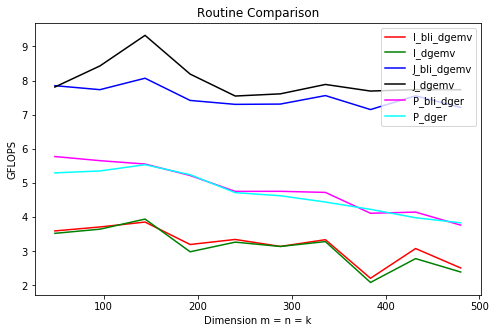

In [5]:
directory = join("..", "data")
filenames = ["output_I_bli_dgemv", "output_I_dgemv", "output_J_bli_dgemv",
            "output_J_dgemv", "output_P_bli_dger", "output_P_dger"]
labels = ["I_bli_dgemv", "I_dgemv", "J_bli_dgemv", "J_dgemv", "P_bli_dger", "P_dger"]
colors = ["r", "g", "b", "k", "magenta", "cyan"]

fig_size = [8, 5]
fix, ax = plt.subplots(1, figsize=fig_size)
for file, label, color in zip(filenames, labels, colors):
    data = get_matlab_data(directory, file)
    if np.any(data[:, 5] > 1e-10):
        raise Exception("Hmmm, better check if there is an accuracy problem")
    ax.plot(data[:, 0], data[:, 4], color=color, label=label)
ax.set_title("Routine Comparison")
ax.set_xlabel("Dimension m = n = k")
ax.set_ylabel("GFLOPS")
ax.legend(loc="upper right")
plt.show()

### Conclusions
* The best way to perform **matrix - matrix** multiplication is in
terms of **matrix - vector** multiplication, this is because we are
dealing with **column major order**, and **matrix - vector**
procedure traverses along the columns of `C`, hence contiguous
stored elements can stay in cache, which reduces the amount of
reading operations for every element are reduced.
* **BLIS** calls under the hood, the same routine as **BLAS** does,
the differences in performance shown in the above plot must be
interpreted as "noise"
* Since we work with **column major order**, traversing `A` and `C`
by rows, really has a big negative impact on performance.